# EBGAN(Energy based GAN)

$$L_D^{EBGAN} = D_{AE}(x) + max(0, m - D_{AE}(G(z)))$$

$$L_G^{EBGAN} = D_{AE}(G(z)) + \lambda PT$$

## EBGAN 특징
- Discriminator를 **Auto-encoder**로 사용
- Loss function을 설정하는 경우 Nash Equilibrium이 존재하게 된다고 하며, 그 때의 Value function의 값과 그것을 만족하는 Energy값이 존재한다는 것을 수식적으로 증명하여 Loss function을 적용함



## 1. Import Libs

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid

import gzip
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

True


## 2. Setting Hyperparameters & dir

In [2]:
num_epochs = 30
learning_rate = 0.0002
batch_size = 64
# img_size = 64
z_dim = 62
sample_num = 64
beta1 = 0.5
beta2 = 0.999
margin = max(1, batch_size / 64.)
pt_loss_weight = 0.1

result_dir = './save_results/MNIST/EBGAN'
model_dir = './save_models/MNIST/EBGAN'

if not os.path.exists(result_dir):
    os.mkdir(result_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

## 3. Load dataset

In [3]:
def load_mnist(dataset):
    data_dir = os.path.join("./data", dataset)
    
    def extract_data(filename, num_data, head_size, data_size):
        with gzip.open(filename) as bytestream:
            bytestream.read(head_size)
            buf = bytestream.read(data_size * num_data)
            data = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
        return data

    data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
    trX = data.reshape((60000, 28, 28, 1))

    data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
    trY = data.reshape((60000))

    data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
    teX = data.reshape((10000, 28, 28, 1))

    data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
    teY = data.reshape((10000))

    trY = np.asarray(trY).astype(np.int)
    teY = np.asarray(teY)

    X = np.concatenate((trX, teX), axis=0)
    y = np.concatenate((trY, teY), axis=0).astype(np.int)

    seed = 547
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)

    y_vec = np.zeros((len(y), 10), dtype=np.float)
    for i, label in enumerate(y):
        y_vec[i, y[i]] = 1

    X = X.transpose(0, 3, 1, 2) / 255.
    # y_vec = y_vec.transpose(0, 3, 1, 2)

    X = torch.from_numpy(X).type(torch.FloatTensor)
    y_vec = torch.from_numpy(y_vec).type(torch.FloatTensor)
    return X, y_vec

In [4]:
data_X, data_Y = load_mnist("MNIST")
print(data_X.size())
print(data_Y.size())
print(data_X.__getitem__(11).size())

torch.Size([70000, 1, 28, 28])
torch.Size([70000, 10])
torch.Size([1, 28, 28])


## 4. Build Models

### 4.1 Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, input_height, input_width, input_dim, output_dim):
        super(Generator, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)), # nn.BatchNorm2d()
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid(),
        )
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
        
    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
        x = self.deconv(x)
        return x

### 4.2 Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_height, input_width, input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.ReLU()
        )
        
        self.code = nn.Sequential(
            nn.Linear(64 * (self.input_height // 2) * (self.input_width // 2), 32)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(32, 64 * (self.input_height // 2) * (self.input_width // 2)),
            nn.BatchNorm1d(64 * (self.input_height // 2) * (self.input_width // 2)),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            # nn.Sigmoid()
        )
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        code = self.code(x)
        x = self.fc(code)
        x = x.view(-1, 64, (self.input_height // 2), (self.input_width // 2))
        x = self.deconv(x)
        return x, code

## utils
### pullaway_loss

In [7]:
def pullaway_loss(embeddings):
    """ pullaway_loss tensorflow version code
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        similarity = tf.matmul(
        normalized_embeddings, normalized_embeddings, transpose_b=True)
        batch_size = tf.cast(tf.shape(embeddings)[0], tf.float32)
        pt_loss = (tf.reduce_sum(similarity) - batch_size) / (batch_size * (batch_size - 1))
        return pt_loss
    """
    norm = torch.sqrt(torch.sum(embeddings ** 2, 1, keepdim=True))
    normalized_embeddings = embeddings / norm
    similarity = torch.matmul(normalized_embeddings, normalized_embeddings.transpose(1, 0))
    batch_size = embeddings.size()[0]
    pt_loss = (torch.sum(similarity) - batch_size) / (batch_size * (batch_size - 1))
    return pt_loss

In [8]:
def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
    x = range(len(hist['d_loss']))

    y1 = hist['d_loss']
    y2 = hist['g_loss']

    plt.plot(x, y1, label='d_loss')
    plt.plot(x, y2, label='g_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')

    plt.savefig(path)

    plt.close()

## 5. Models & Optimizers

In [9]:
G = Generator(28, 28, z_dim, 1)
D = Discriminator(28, 28, 1, 1)
G.initialize_weights()
D.initialize_weights()

g_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(beta1, beta2))
d_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=(beta1, beta2))

MSE_loss = nn.MSELoss()

sample_z = torch.zeros((batch_size, z_dim))

if USE_CUDA:
    G = G.cuda()
    D = D.cuda()
    sample_z = sample_z.cuda()

In [10]:
num_param_G = 0
for param in G.parameters():
    num_param_G += param.numel()
    
num_param_D = 0
for param in G.parameters():
    num_param_D += param.numel()

print(G)
print("Total number of params in Generator : " , num_param_G)
print("==================================")
print(D)
print("Total number of params in Discriminator : ", num_param_D)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)
Total number of params in Generator :  6640193
Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (code): Sequential(
    (0): Linear(in_features=12544, out_features=32, bias=True)
  )
  (fc): Sequential(
    (0): Linear(

## 7. Load models

In [11]:
try:
    G.load_state_dict(torch.load(model_dir + '/ebgan_generator.pkl'))
    D.load_state_dict(torch.load(model_dir + '/ebgan_discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



## 7. Train

$$L_D^{EBGAN} = D_{AE}(x) + max(0, m - D_{AE}(G(z)))$$

$$L_G^{EBGAN} = D_{AE}(G(z)) + \lambda\cdot PT$$

In [12]:
train_hist = {}
train_hist['d_loss'] = []
train_hist['g_loss'] = []
train_hist['per_epoch_time'] = []
train_hist['total_time'] = []

In [13]:
D.train()
print('training start!!!')
start_time = time.time()

# for epoch in range(1):
for epoch in range(1, num_epochs + 1):
    G.train()
    epoch_start_time = time.time()
    
    for iter in range(len(data_X) // batch_size):
        images = data_X[iter*batch_size:(iter + 1)*batch_size]
        z = torch.rand((batch_size, z_dim))

        if USE_CUDA:
            images = images.cuda()
            z = z.cuda()

        d_optimizer.zero_grad()
        
        # Update D network
        d_real, _ = D(images)
        d_loss_real = MSE_loss(d_real, images)
        
        fake_images = G(z)
        d_fake, _ = D(fake_images)
        d_loss_fake = MSE_loss(d_fake, fake_images.detach())
        
        d_loss = d_loss_real + torch.clamp(margin - d_loss_fake, min=0)
    
        train_hist['d_loss'].append(d_loss.item())
        
        d_loss.backward()
        d_optimizer.step()
        
        # Update G network
        g_optimizer.zero_grad()
        
        fake_images = G(z)
        d_fake, d_fake_code = D(fake_images)
        d_loss_fake = MSE_loss(d_fake, fake_images.detach())
        
        g_loss = d_loss_fake + pt_loss_weight * pullaway_loss(d_fake_code.view(batch_size, -1))
        
        train_hist['g_loss'].append(g_loss.item())
        
        g_loss.backward()
        g_optimizer.step()
        
        if ((iter + 1) % 100) == 0:
            print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
                  %(epoch, num_epochs, (iter + 1), len(data_X)//batch_size, d_loss.item(), g_loss.item()))

    train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
    
    # Save
    G.eval()

    samples = G(sample_z)
    
    generated_sample = samples.view(sample_num, 1, 28, 28)
    save_image(generated_sample.data, result_dir + '/generated_images-%d.png'%(epoch + 1))
    
train_hist['total_time'].append(time.time() - start_time)
print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(train_hist['per_epoch_time']), num_epochs, train_hist['total_time'][0]))

torch.save(G.state_dict(), model_dir + '/ebgan_generator.pkl')
torch.save(D.state_dict(), model_dir + '/ebgan_discriminator.pkl')

loss_plot(train_hist, result_dir, 'EBGAN')

training start!!!
Epoch [1/30], Step [100/1093], D_loss: 0.6995, G_loss: 0.4432
Epoch [1/30], Step [200/1093], D_loss: 0.0668, G_loss: 1.1493
Epoch [1/30], Step [300/1093], D_loss: 0.0349, G_loss: 1.1456
Epoch [1/30], Step [400/1093], D_loss: 0.0379, G_loss: 1.1710
Epoch [1/30], Step [500/1093], D_loss: 0.0314, G_loss: 1.1158
Epoch [1/30], Step [600/1093], D_loss: 0.0345, G_loss: 1.0967
Epoch [1/30], Step [700/1093], D_loss: 0.0343, G_loss: 1.1075
Epoch [1/30], Step [800/1093], D_loss: 0.0331, G_loss: 1.0018
Epoch [1/30], Step [900/1093], D_loss: 0.0304, G_loss: 1.0194
Epoch [1/30], Step [1000/1093], D_loss: 0.0262, G_loss: 1.0207
Epoch [2/30], Step [100/1093], D_loss: 0.0289, G_loss: 1.0080
Epoch [2/30], Step [200/1093], D_loss: 0.0265, G_loss: 1.0339
Epoch [2/30], Step [300/1093], D_loss: 0.0474, G_loss: 1.3275
Epoch [2/30], Step [400/1093], D_loss: 0.0280, G_loss: 1.0741
Epoch [2/30], Step [500/1093], D_loss: 0.0241, G_loss: 1.0304
Epoch [2/30], Step [600/1093], D_loss: 0.0274, G_lo

Epoch [14/30], Step [200/1093], D_loss: 0.1790, G_loss: 1.4576
Epoch [14/30], Step [300/1093], D_loss: 0.1083, G_loss: 1.0463
Epoch [14/30], Step [400/1093], D_loss: 0.1208, G_loss: 1.2935
Epoch [14/30], Step [500/1093], D_loss: 0.1326, G_loss: 1.5585
Epoch [14/30], Step [600/1093], D_loss: 0.2375, G_loss: 1.8932
Epoch [14/30], Step [700/1093], D_loss: 0.1253, G_loss: 1.5295
Epoch [14/30], Step [800/1093], D_loss: 0.2481, G_loss: 1.9715
Epoch [14/30], Step [900/1093], D_loss: 0.2036, G_loss: 1.6639
Epoch [14/30], Step [1000/1093], D_loss: 0.1298, G_loss: 1.1985
Epoch [15/30], Step [100/1093], D_loss: 0.1516, G_loss: 2.2198
Epoch [15/30], Step [200/1093], D_loss: 0.1312, G_loss: 1.5252
Epoch [15/30], Step [300/1093], D_loss: 0.1014, G_loss: 1.0757
Epoch [15/30], Step [400/1093], D_loss: 0.0988, G_loss: 1.3147
Epoch [15/30], Step [500/1093], D_loss: 0.2334, G_loss: 2.0190
Epoch [15/30], Step [600/1093], D_loss: 0.1062, G_loss: 1.3581
Epoch [15/30], Step [700/1093], D_loss: 0.1402, G_loss

Epoch [27/30], Step [200/1093], D_loss: 0.0679, G_loss: 1.4062
Epoch [27/30], Step [300/1093], D_loss: 0.0870, G_loss: 3.6483
Epoch [27/30], Step [400/1093], D_loss: 0.2563, G_loss: 2.6099
Epoch [27/30], Step [500/1093], D_loss: 0.1054, G_loss: 1.4614
Epoch [27/30], Step [600/1093], D_loss: 0.0763, G_loss: 1.3471
Epoch [27/30], Step [700/1093], D_loss: 0.1401, G_loss: 2.4566
Epoch [27/30], Step [800/1093], D_loss: 0.0890, G_loss: 1.3827
Epoch [27/30], Step [900/1093], D_loss: 0.0911, G_loss: 1.3432
Epoch [27/30], Step [1000/1093], D_loss: 0.0743, G_loss: 2.0273
Epoch [28/30], Step [100/1093], D_loss: 0.1036, G_loss: 3.2331
Epoch [28/30], Step [200/1093], D_loss: 0.0687, G_loss: 1.4301
Epoch [28/30], Step [300/1093], D_loss: 0.0754, G_loss: 1.1374
Epoch [28/30], Step [400/1093], D_loss: 0.0744, G_loss: 1.0893
Epoch [28/30], Step [500/1093], D_loss: 0.0718, G_loss: 2.0992
Epoch [28/30], Step [600/1093], D_loss: 0.0733, G_loss: 1.9363
Epoch [28/30], Step [700/1093], D_loss: 0.0802, G_loss

## 8. Display generated data

In [14]:
import imageio

images = []
for epoch in range(num_epochs + 1):
    try:
        img_name = result_dir + '/generated_images-%d.png'%(epoch + 1)
        images.append(imageio.imread(img_name))
    except:
        pass
    
imageio.mimsave(result_dir + '/fake_images_total.gif', images, fps=4)


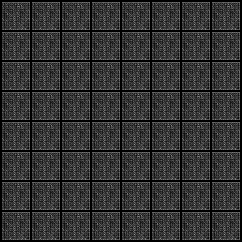

In [15]:
import io
import base64
from IPython.display import HTML

video = io.open(result_dir + '/fake_images_total.gif', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

## 9. Use model to generate new sample

In [16]:
try:
    G.load_state_dict(torch.load(model_dir + '/ebgan_generator.pkl'))
    D.load_state_dict(torch.load(model_dir + '/ebgan_discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



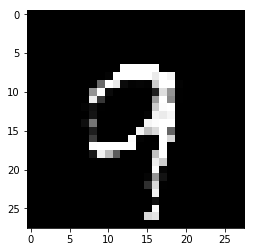

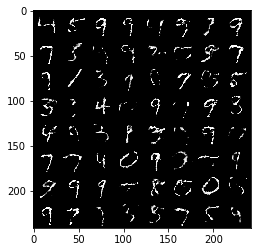

In [17]:
z = torch.randn(sample_num, z_dim)

if USE_CUDA:
    z = z.cuda()
    
G.eval()
fake_images = G(z)
plt.imshow(fake_images[2].cpu().view(28, 28).data.numpy(), cmap='gray')
plt.show()

plt.imshow(make_grid(fake_images.data.view(sample_num,1,28,28)).cpu().permute(1,2,0).numpy())
plt.show()